# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


## ⚙️ Import Libraries

In [4]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("TensorFlow version: ", tf.__version__)

from tensorflow.keras import mixed_precision
AUTOTUNE = tf.data.AUTOTUNE

# Import other libraries
import cv2
import hashlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

TensorFlow version:  2.17.1


In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)

    policy = mixed_precision.Policy('mixed_bfloat16')

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

    policy = mixed_precision.Policy('mixed_float16')

    # !pip install keras-cv
    # import keras_cv

# Import the mixed precision according to the strategy
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Not connected to a TPU runtime. Using CPU/GPU strategy
Compute dtype: float16
Variable dtype: float32


## ⏳ Load the Data

In [6]:
file_path = "training_set_trimmed.npz"
data_new = np.load(file_path)

In [7]:
images = data_new['images']
labels = data_new['labels']

# Check the shape of the dataset
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (11959, 96, 96, 3)
Shape of labels: (11959, 1)


In [8]:
from collections import Counter

# Flatten the 'labels' array to 1D
labels_flat = labels.ravel()  # or labels.flatten()

# Count the occurrences of each class in the flattened labels array
class_counts = Counter(labels_flat)

# Print the number of images for each class
print("Number of images per class:")
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} images")

Number of images per class:
Class 0: 852 images
Class 1: 2181 images
Class 2: 1085 images
Class 3: 2026 images
Class 4: 849 images
Class 5: 993 images
Class 6: 2330 images
Class 7: 1643 images


In [9]:
# Per la visualizzazione delle augmentation
classes = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# Assuming labels are already in integer format from 0 to 7
# Create a one-hot encoding
num_classes = len(classes)
labels_encoded = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

In [10]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, random_state=seed, test_size=0.2, stratify=np.argmax(labels, axis=1)
)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=np.argmax(y_train_val, axis=1)
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define input shape and output shape
input_shape = X_train.shape[1:]
output_shape = 8

print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")


X_train shape: (7653, 96, 96, 3), y_train shape: (7653, 1)
X_val shape: (1914, 96, 96, 3), y_val shape: (1914, 1)
X_test shape: (2392, 96, 96, 3), y_test shape: (2392, 1)
Input Shape: (96, 96, 3), Output Shape: 8


In [11]:
# Define batch size, number of epochs, learning rate
batch_size = 64
epochs = 100
tl_learning_rate = 5e-3
ft_learning_rate = 5e-5

# Dropout
dropout_rate=0.24

# Early Stopping
es_patience=15

# Learing Rate Scheduler
reducing_factor=0.1
lr_patience=10
min_lr=1e-7

# Augmentation
bright = 0.16
contrast = 0.12
rotation = 0.24

# Print batch size, epochs, learning rate
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {ft_learning_rate}")
print(f"Dropout rate: {dropout_rate} ")
print(f"Early stopping patience: {es_patience}")

Batch Size: 64, Epochs: 100, Learning Rate: 5e-05
Dropout rate: 0.24 
Early stopping patience: 15


In [12]:
def schedule(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.07)

lrs = tfk.callbacks.LearningRateScheduler(schedule, verbose=0)

tl_es = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, restore_best_weights=True, mode='max')
ft_es = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, restore_best_weights=True, mode='max')

# Define two callback functions for early stopping and learnin g rate reduction
callbacks=[
    ft_es,
    lrs
]

## 🛠️ Train and Save the Model

### creo augmentation

In [21]:
# Augmentation

contrast = 0.12
rotation = 0.24
hue=0.2
saturation=1.5
threshold = 190 #numero tra 0 e 255
bits= 600 #più è alto è piu sembra ci sai luce che fa diventare tutto bianco
gamma = 0.9 #da 0.8 a 0.14 ha senso
bright = 0.16

In [22]:
def create_augmentation(k, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma):
    if k == 1:
        return tfk.Sequential([
            tfkl.Lambda(lambda x: tf.image.adjust_gamma(x, gamma=0.9, gain=1.0)),
            tfkl.RandomFlip(name='RandomFlip', seed=seed),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment1')

    elif k == 2:
        return tfk.Sequential([
            tfkl.RandomContrast(contrast, seed=seed),
            tfkl.RandomBrightness(bright, seed=seed),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomFlip(name='RandomFlip', seed=seed),
            tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment2')


    elif k == 4:
        return tfk.Sequential([
            tfkl.RandomBrightness(bright, seed=seed),
            tfkl.RandomContrast(contrast, seed=seed),
            tfkl.Lambda(lambda x: tf.image.central_crop(x, central_fraction=0.5)),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment4')

    elif k == 5:
        return tfk.Sequential([
            tfkl.Lambda(lambda x: tf.where(x < 190, x, 1.0 - x)),
            tfkl.RandomFlip(name='RandomFlip', seed=seed),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment5')

    elif k == 6:
        return tfk.Sequential([
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),  # Ritaglio casuale dopo la scalaturs
            tfkl.Lambda(lambda x: tf.image.adjust_contrast(x, 600)),
            tfkl.Lambda(lambda x: tf.image.central_crop(x, central_fraction=0.7)),
            tfkl.RandomBrightness(bright+0.02, seed=seed),
        ], name='Augment6')

    elif k == 3:
        return tfk.Sequential([
            tfkl.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
            tfkl.Lambda(lambda x: tf.image.adjust_brightness(x, 0.16)),
            tfkl.Lambda(lambda x: tf.image.adjust_contrast(x, 0.12)),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment3')

    elif k == 7:
        return tfk.Sequential([
            tfkl.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
            tfkl.Lambda(lambda x: tf.image.adjust_brightness(x, 0.06)),
            tfkl.Lambda(lambda x: tf.image.adjust_contrast(x, -0.02)),
            tfkl.RandomRotation(rotation, seed=seed),
            tfkl.RandomCrop(input_shape[0], input_shape[1], seed=seed),
        ], name='Augment7')

    else:
        raise ValueError("Invalid value for k. Please choose a number between 1 and 7.")

### Stampa delle augmentation:


Visualizing augmentation method 1


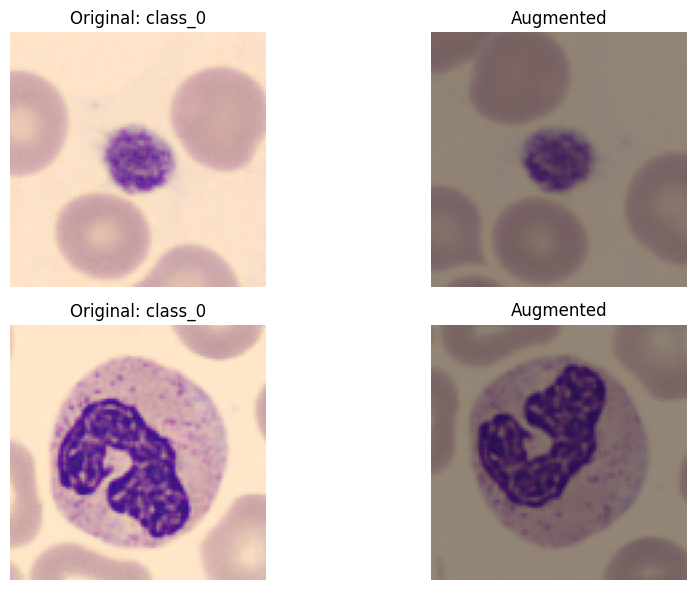

Visualizing augmentation method 2


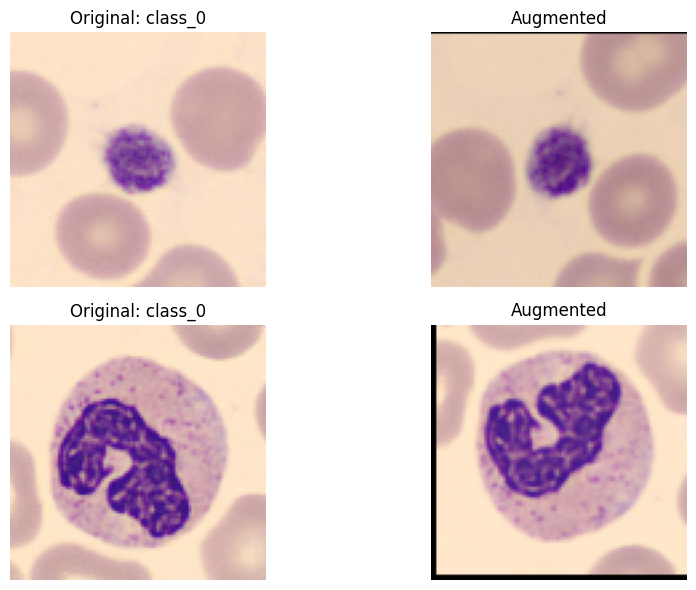

Visualizing augmentation method 3


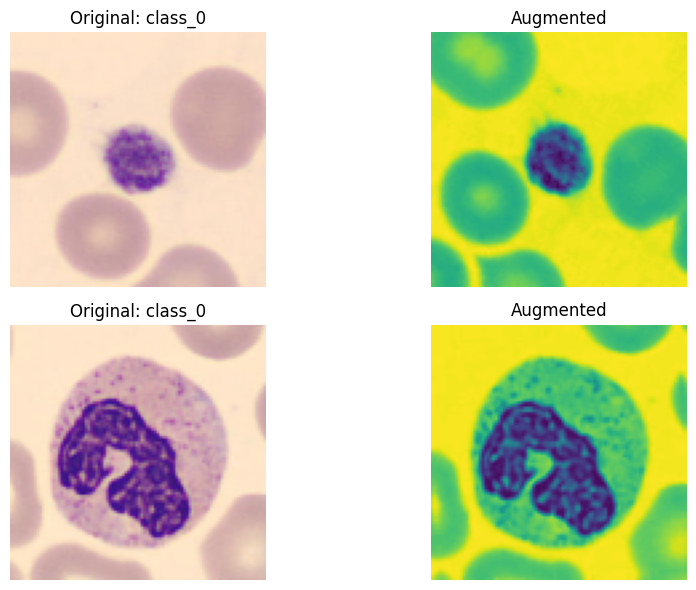

Visualizing augmentation method 4


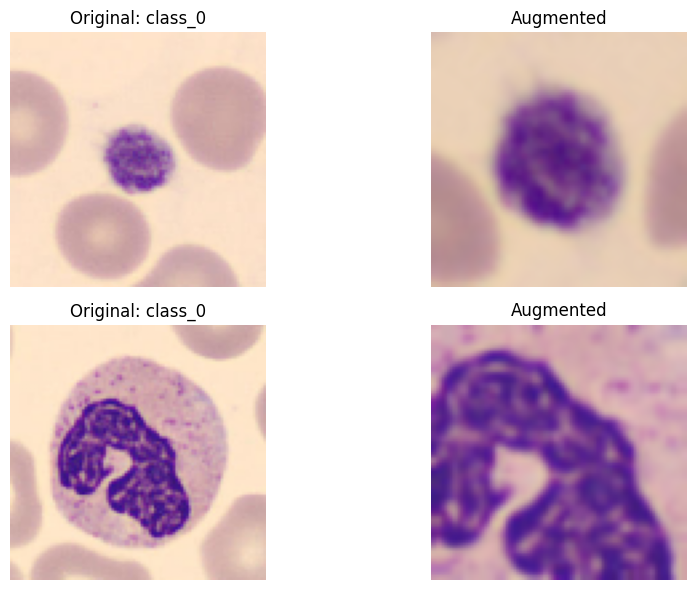

Visualizing augmentation method 5


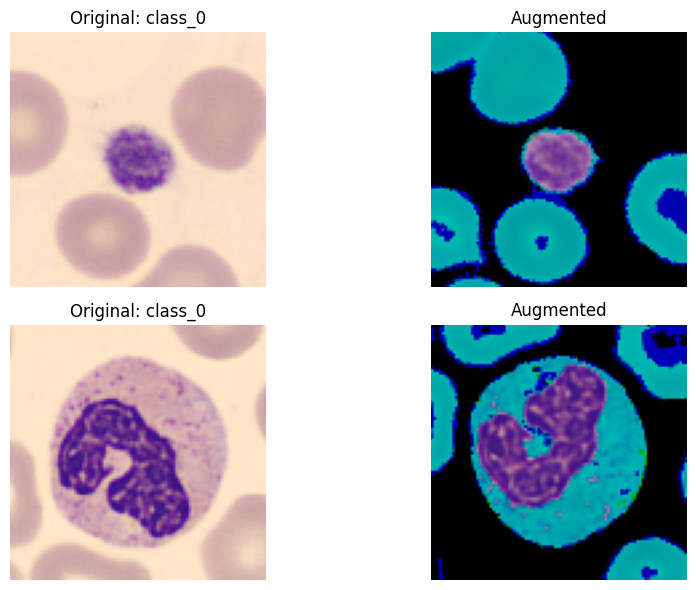

Visualizing augmentation method 6


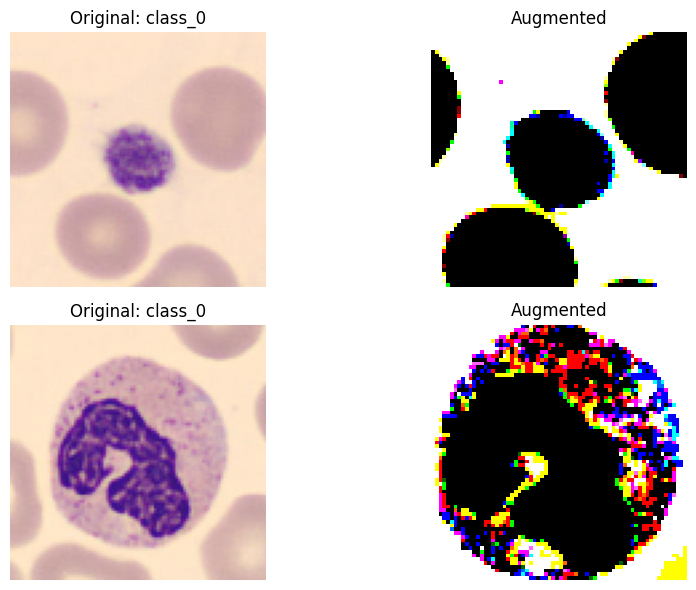

Visualizing augmentation method 7


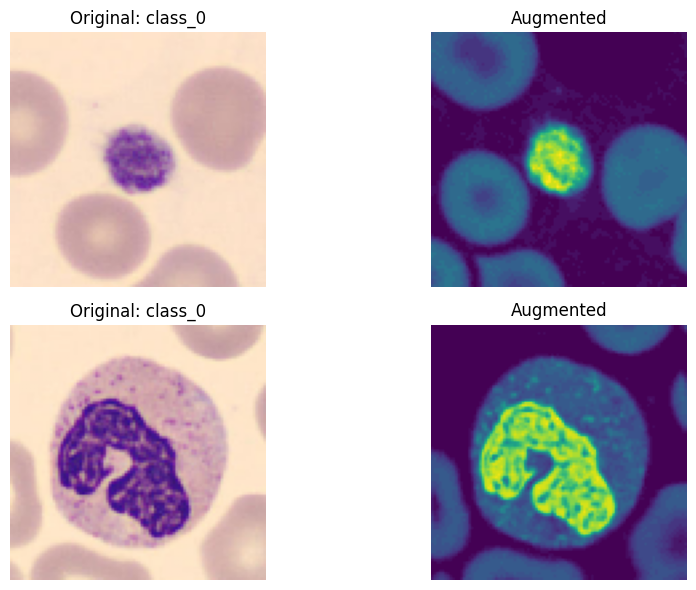

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# Usa solo le prime 10 immagini e le relative etichette
X_train_sample = X_train[:2]
y_train_sample = y_train[:2]
X_train_sample = X_train_sample.astype(np.float64)
y_train_sample = y_train_sample.astype(np.float64)

#augmentation = create_augmentation(k, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma)
# Funzione per visualizzare immagini e informazioni
def debug_augmentation(X_images, y_labels, augmentation_layer):
    num_images = len(X_images)

    # Crea una griglia per visualizzare originali e augmentate
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

    for i in range(num_images):
        # Immagine originale e etichetta
        original_image = X_images[i]
        original_label = np.argmax(y_labels[i])  # Decodifica one-hot a indice di classe

        # Applica data augmentation
        augmented_image = augmentation_layer(tf.expand_dims(original_image, axis=0))[0].numpy()

        # Visualizza immagine originale
        axes[i, 0].imshow(original_image.astype('float32') / 255.0)  # Normalizza per matplotlib
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Original: {classes[original_label]}')

        # Visualizza immagine augmentata
        axes[i, 1].imshow(augmented_image.astype('float32') / 255.0)  # Normalizza per matplotlib
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Augmented')

    plt.tight_layout()
    plt.show()

# Visualizza e controlla le prime 10 immagini
for k in range(1, 8):
    print(f"Visualizing augmentation method {k}")
    augmentation = create_augmentation(k, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma)
    debug_augmentation(X_train_sample, y_train_sample, augmentation)


### Creazione modello

Metodo Callbacks per cambiare ogni epoca l'augmentation da fare

In [26]:
# Callback per cambiare augmentation dinamicamente
class ChangeAugmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma):
        super().__init__()
        self.seed = seed
        self.input_shape = input_shape
        self.contrast = contrast
        self.bright = bright
        self.rotation = rotation
        self.hue = hue
        self.saturation = saturation
        self.threshold = threshold
        self.bits = bits
        self.gamma = gamma

    def on_epoch_begin(self, epoch, logs=None):
        # Scegli un nuovo valore casuale di k (da 1 a 7)
        k = np.random.randint(1, 8)
        print(f"Changing augmentation to Augment{k} for epoch {epoch + 1}")

        # Crea il nuovo layer di augmentation
        new_augmentation = create_augmentation(
            k=k,
            seed=self.seed,
            input_shape=self.input_shape,
            contrast=self.contrast,
            bright=self.bright,
            rotation=self.rotation,
            hue=self.hue,
            saturation=self.saturation,
            threshold=self.threshold,
            bits=self.bits,
            gamma=self.gamma,
        )

        # Modifica il layer di augmentation nel modello
        self.model.layers[1] = new_augmentation  # Assumendo che augmentation sia il secondo layer

In [27]:
def create_model(loss,optimizer, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma):

    # Augment the input
    augmentation = create_augmentation(1, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma)

    supernet = tfk.applications.ConvNeXtSmall(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg",
        classes=8
    )

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    supernet.trainable = False

    tl_model = tf.keras.Sequential([
        tfk.Input(input_shape, name="input_layer"),
        augmentation,
        supernet,
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed)),
        tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed)),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(output_shape, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), dtype='float32', name='output_layer')
    ], name = "ConvNextLarge")

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    tl_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return tl_model, supernet

with strategy.scope():

  loss = tfk.losses.SparseCategoricalCrossentropy(),
  tl_optimizer=tfk.optimizers.Adam(tl_learning_rate)

  # Create a Model connecting input and output
  tl_model, supernet = create_model(loss,tl_optimizer, seed, input_shape, contrast, bright, rotation, hue, saturation, threshold, bits, gamma)

tl_model.summary()

Model: "ConvNextLarge"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Augment1 (Sequential)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_small (Functional)          │ (None, 768)                 │      49,454,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,981,800 (190.67 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 49,454,688 (188.65 MB)

## Transfer Learning

In [28]:
    change_augmentation_cb = ChangeAugmentationCallback(
        seed=seed,
        input_shape=input_shape,
        contrast=contrast,
        bright=bright,
        rotation=rotation,
        hue=hue,
        saturation=saturation,
        threshold=threshold,
        bits=bits,
        gamma=gamma
    )

# Train the model and save its history
history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val,y_val),
    callbacks=[tl_es, change_augmentation_cb],
    #class_weight=class_weights
).history

Changing augmentation to Augment7 for epoch 1
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.4503 - loss: 9.9168 - val_accuracy: 0.6614 - val_loss: 2.6474
Changing augmentation to Augment4 for epoch 2
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.6731 - loss: 2.3213 - val_accuracy: 0.7074 - val_loss: 1.7090
Changing augmentation to Augment5 for epoch 3
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.7003 - loss: 1.6014 - val_accuracy: 0.7685 - val_loss: 1.2686
Changing augmentation to Augment7 for epoch 4
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.7425 - loss: 1.3099 - val_accuracy: 0.7753 - val_loss: 1.1662
Changing augmentation to Augment3 for epoch 5
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.7379 - loss: 1.2478 - val_accuracy: 0.7550 - val_loss: 1.1990
Changing augmentation to Augment5 for epoch 6
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accura

In [29]:
print("Best epoch: ",tl_es.best_epoch)
print("Test label Shape:", y_test.shape)
print("Evaluate on test data")
print("test loss, test acc:", tl_model.evaluate(X_test, y_test))

Best epoch:  43
Test label Shape: (2392, 1)
Evaluate on test data
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8497 - loss: 0.8822
test loss, test acc: [0.8678296804428101, 0.8591136932373047]


In [30]:
with strategy.scope():
    ft_model = tl_model
    ft_model.set_weights(tl_model.get_weights())
    ft_optimizer=tfk.optimizers.Adam(ft_learning_rate)
    ft_model.compile(loss=loss, optimizer=ft_optimizer, metrics=['accuracy'])
del tl_model
print("Number of layers in the supernet: ", len(ft_model.get_layer(supernet.name).layers))

Number of layers in the supernet:  260


In [31]:
with strategy.scope():
    # Itera sugli ultimi layer del supernet, al contrario
    for i in reversed(range(len(ft_model.get_layer(supernet.name).layers))):
        layer = ft_model.get_layer(supernet.name).layers[i]

        # Rendi trainable solo i layer convoluzionali
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D,
                              tf.keras.layers.SeparableConv2D, tf.keras.layers.Conv2DTranspose)):
            layer.trainable = True
        else:
            layer.trainable = False

        # Stampa il nome del layer e il suo stato di trainable
        print(i, layer.name, layer.trainable)

    # Compila il modello con il nuovo stato dei layer
    ft_optimizer = tfk.optimizers.Adam(ft_learning_rate)
    ft_model.compile(loss=loss, optimizer=ft_optimizer, metrics=['accuracy'])

# Mostra il sommario del modello
ft_model.summary()


259 layer_normalization_2 False
258 global_average_pooling2d_2 False
257 convnext_small_stage_3_block_2_identity False
256 convnext_small_stage_3_block_2_layer_scale False
255 convnext_small_stage_3_block_2_pointwise_conv_2 False
254 convnext_small_stage_3_block_2_gelu False
253 convnext_small_stage_3_block_2_pointwise_conv_1 False
252 convnext_small_stage_3_block_2_layernorm False
251 convnext_small_stage_3_block_2_depthwise_conv True
250 convnext_small_stage_3_block_1_identity False
249 convnext_small_stage_3_block_1_layer_scale False
248 convnext_small_stage_3_block_1_pointwise_conv_2 False
247 convnext_small_stage_3_block_1_gelu False
246 convnext_small_stage_3_block_1_pointwise_conv_1 False
245 convnext_small_stage_3_block_1_layernorm False
244 convnext_small_stage_3_block_1_depthwise_conv True
243 convnext_small_stage_3_block_0_identity False
242 convnext_small_stage_3_block_0_layer_scale False
241 convnext_small_stage_3_block_0_pointwise_conv_2 False
240 convnext_small_stage_3_b

Model: "ConvNextLarge"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Augment1 (Sequential)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_small (Functional)          │ (None, 768)                 │      49,454,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,981,800 (190.67 MB)

 Trainable params: 1,203,912 (4.59 MB)

 Non-trainable params: 48,777,888 (186.07 MB)

## Fine Tuning

In [32]:
ft_total_epochs = tl_es.best_epoch + epochs

history = ft_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=ft_total_epochs,
    validation_data=(X_val,y_val),
    initial_epoch=tl_es.best_epoch,
    callbacks = [ft_es,change_augmentation_cb]
).history

ft_model.save('weights.keras')

Changing augmentation to Augment4 for epoch 44
Epoch 44/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 77s 478ms/step - accuracy: 0.8423 - loss: 0.7991 - val_accuracy: 0.8939 - val_loss: 0.5870
Changing augmentation to Augment6 for epoch 45
Epoch 45/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.8998 - loss: 0.5865 - val_accuracy: 0.9101 - val_loss: 0.5435
Changing augmentation to Augment2 for epoch 46
Epoch 46/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9094 - loss: 0.5594 - val_accuracy: 0.9201 - val_loss: 0.5052
Changing augmentation to Augment2 for epoch 47
Epoch 47/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.9229 - loss: 0.5094 - val_accuracy: 0.9279 - val_loss: 0.4834
Changing augmentation to Augment1 for epoch 48
Epoch 48/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 379ms/step - accuracy: 0.9321 - loss: 0.4805 - val_accuracy: 0.9357 - val_loss: 0.4644
Changing augmentation to Augment2 for epoch 49
Epoch 49/143
120/120 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/s

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9727 - loss: 0.2975
Test Accuracy: 97.66%
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step


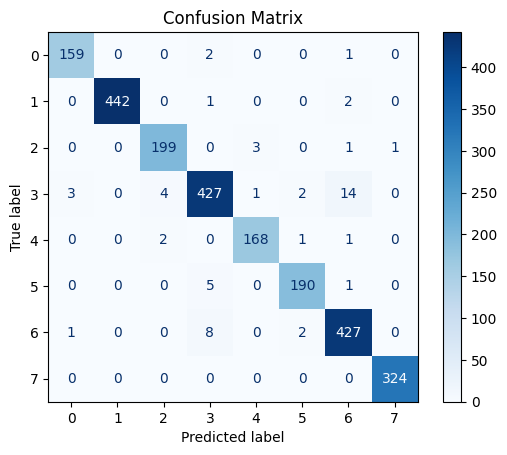

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = ft_model.evaluate(X_test, y_test, batch_size=64)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
y_pred = np.argmax(ft_model.predict(X_test), axis=1)

# Display a confuasion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(ft_model.output_shape[-1]))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [36]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [37]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>